# **Modelos**

## **Modulos y librerias necesarios**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# --- Scikit-learn Core ---
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import joblib

# --- Evaluation Metrics and Display (Scikit-learn) ---
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)

# --- Advanced Ensemble Models ---
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# --- Global Constants ---
RANDOM_STATE = 42

## **Cargue de datos y train test split con preprocesamiento**

In [33]:
path=os.path.join("..","data", "processed", "telco_churn_cleaned.csv")
df=pd.read_csv(path, delimiter=",")

In [34]:
y=df['Churn']
X=df.drop(columns=['Churn'])

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

In [ ]:
# Train/Test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

# Preprocesamiento (OneHot para categóricas + escalado opcional para numéricas)
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(with_mean=False), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), cat_cols),
    ]
)

# **Ramdon Forest**

Entrenando Random Forest...
Fitting 5 folds for each of 96 candidates, totalling 480 fits

Mejores parámetros: {'model__criterion': 'entropy', 'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 400}
Mejor AUC (CV): 0.8452

Accuracy: 0.799
Precision: 0.654
Recall: 0.516
F1: 0.577
AUC: 0.842


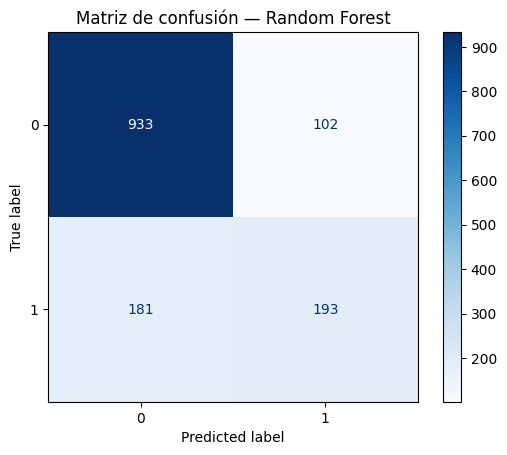

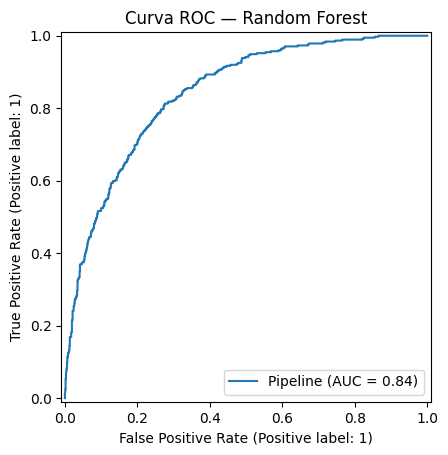

In [38]:
# --- Configuración base ---
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

pipe_rf = Pipeline(steps=[("preprocess", preprocess), ("model", rf)])

# --- Espacio de hiperparámetros (pequeño para pruebas iniciales) ---
param_grid_rf = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2],
    "model__max_features": ["sqrt", "log2"],
    "model__criterion": ["gini", "entropy"],
}

# --- GridSearchCV ---
gs_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    cv=cv5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1,
)

print("Entrenando Random Forest...")
gs_rf.fit(X_train, y_train)

print("\nMejores parámetros:", gs_rf.best_params_)
print("Mejor AUC (CV):", round(gs_rf.best_score_, 4))

# --- Evaluación en test ---
best_rf = gs_rf.best_estimator_
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

print("\nAccuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Precision:", round(precision_score(y_test, y_pred), 3))
print("Recall:", round(recall_score(y_test, y_pred), 3))
print("F1:", round(f1_score(y_test, y_pred), 3))
print("AUC:", round(roc_auc_score(y_test, y_proba), 3))

# --- Matriz de confusión ---
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap="Blues")
plt.title("Matriz de confusión — Random Forest")
plt.show()

# --- Curva ROC ---
RocCurveDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("Curva ROC — Random Forest")
plt.show()


El modelo **Random Forest** muestra un desempeño sólido y balanceado en la predicción del *churn*.
La **matriz de confusión** refleja que el modelo identifica correctamente a la mayoría de los clientes que permanecen (933 verdaderos negativos) y logra detectar una parte importante de los que se dan de baja (193 verdaderos positivos), aunque aún existen falsos negativos (181) que representan clientes que abandonan pero no fueron detectados.

En cuanto a las métricas, el modelo alcanza una **exactitud del 79.9 %**, con una **precisión del 65.4 %**, lo que indica que, cuando predice un cliente como “churn”, suele acertar. El **recall del 51.6 %** muestra que capta alrededor de la mitad de los clientes que efectivamente abandonan, mientras que el **F1-score (0.577)** refleja un equilibrio razonable entre precisión y sensibilidad. Finalmente, el **AUC de 0.842** evidencia una buena capacidad discriminativa general, indicando que el modelo separa adecuadamente los casos de churn y no churn.

En conjunto, estos resultados sugieren que el modelo Random Forest ofrece un rendimiento competitivo, con margen de mejora en la detección de los casos de abandono.


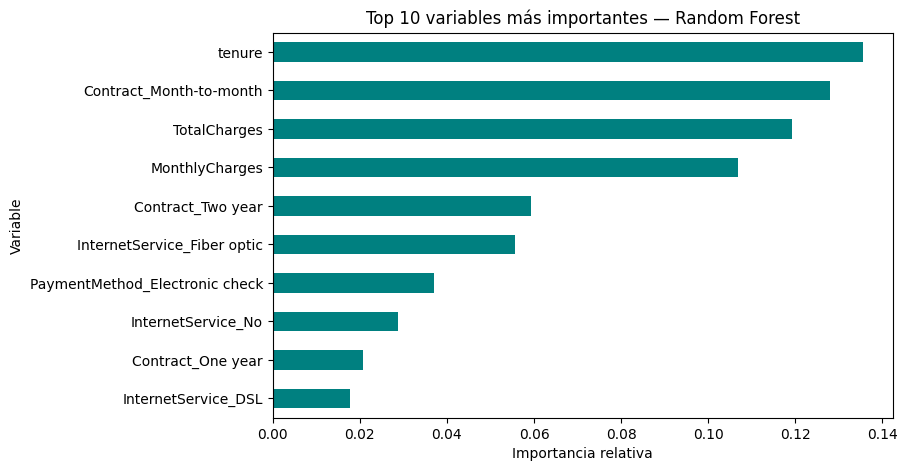

tenure                            0.135621
Contract_Month-to-month           0.127898
TotalCharges                      0.119315
MonthlyCharges                    0.106952
Contract_Two year                 0.059367
InternetService_Fiber optic       0.055688
PaymentMethod_Electronic check    0.036926
InternetService_No                0.028819
Contract_One year                 0.020686
InternetService_DSL               0.017702
dtype: float64

In [39]:
# --- Obtener nombres de las columnas tras el OneHotEncoder ---
ohe = best_rf.named_steps['preprocess'].named_transformers_['cat']
num_features = num_cols
cat_features = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_features, cat_features])

# --- Obtener las importancias ---
model = best_rf.named_steps['model']
importances = pd.Series(model.feature_importances_, index=feature_names)

# ---  Seleccionar las 10 más importantes ---
top_imp = importances.sort_values(ascending=False).head(10)

# --- Graficar ---
plt.figure(figsize=(8, 5))
top_imp.sort_values().plot.barh(color="teal")
plt.title("Top 10 variables más importantes — Random Forest")
plt.xlabel("Importancia relativa")
plt.ylabel("Variable")
plt.show()

top_imp

Las variables más relevantes para el modelo **Random Forest** indican los factores con mayor influencia en la probabilidad de cancelación de clientes.
El **tenure** (tiempo de permanencia) destaca como el principal predictor: a menor tiempo con la compañía, mayor probabilidad de abandono. Le siguen el tipo de contrato, especialmente **Contract_Month-to-month**, que representa a los clientes con contratos mensuales, un grupo típicamente más propenso al churn.

También resultan influyentes los indicadores financieros, como **TotalCharges** y **MonthlyCharges**, lo que sugiere que los montos de facturación mensuales y acumulados influyen directamente en la decisión de permanencia. Otras variables destacadas son **Contract_Two year** (contratos largos que reducen la cancelación), el tipo de servicio de internet (**Fiber optic**) y el método de pago **Electronic check**, asociado frecuentemente a mayores tasas de abandono.

En conjunto, el modelo identifica que la duración del contrato, la facturación y el tipo de servicio son los factores que más determinan el comportamiento de churn entre los clientes.


# **XGBoost**

Entrenando XGBoost...
Fitting 5 folds for each of 192 candidates, totalling 960 fits

Mejores parámetros: {'model__colsample_bytree': 0.7, 'model__gamma': 0.0, 'model__max_depth': 3, 'model__min_child_weight': 1, 'model__reg_alpha': 0.5, 'model__reg_lambda': 1.0, 'model__subsample': 0.7}
Mejor AUC (CV): 0.8448

Accuracy: 0.75
Precision: 0.52
Recall: 0.778
F1: 0.623
AUC: 0.844


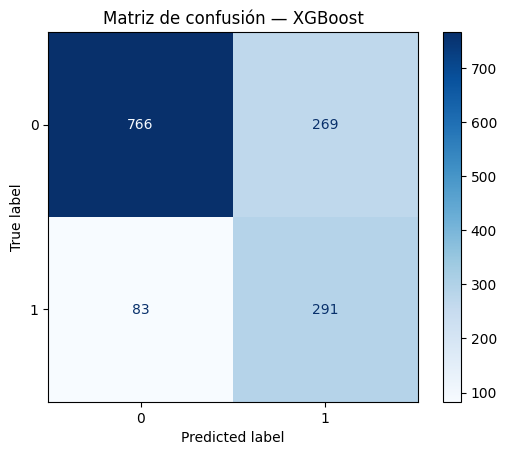

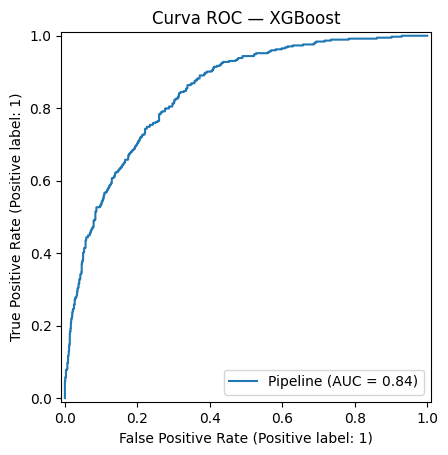

In [40]:
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Ratio de clases 
pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

xgb = XGBClassifier(
    random_state=RANDOM_STATE,
    n_estimators=500,
    learning_rate=0.05,
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist',
    n_jobs=-1,
    scale_pos_weight=float(pos_weight)
)

pipe_xgb = Pipeline(steps=[("preprocess", preprocess), ("model", xgb)])

# Espacio de hiperparámetros (controlado)
param_grid_xgb = {
    "model__max_depth": [3, 4, 6],
    "model__min_child_weight": [1, 3],
    "model__gamma": [0.0, 0.2],
    "model__subsample": [0.7, 0.9],
    "model__colsample_bytree": [0.7, 0.9],
    "model__reg_alpha": [0.0, 0.5],
    "model__reg_lambda": [1.0, 2.0],
}

# GridSearchCV
gs_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_grid_xgb,
    cv=cv5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

print("Entrenando XGBoost...")
gs_xgb.fit(X_train, y_train)

print("\nMejores parámetros:", gs_xgb.best_params_)
print("Mejor AUC (CV):", round(gs_xgb.best_score_, 4))

# Evaluación en test
best_xgb = gs_xgb.best_estimator_
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

print("\nAccuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Precision:", round(precision_score(y_test, y_pred), 3))
print("Recall:", round(recall_score(y_test, y_pred), 3))
print("F1:", round(f1_score(y_test, y_pred), 3))
print("AUC:", round(roc_auc_score(y_test, y_proba), 3))

# Matriz de confusión
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap="Blues")
plt.title("Matriz de confusión — XGBoost")
plt.show()

# Curva ROC
RocCurveDisplay.from_estimator(best_xgb, X_test, y_test)
plt.title("Curva ROC — XGBoost")
plt.show()


El modelo **XGBoost** presenta un rendimiento equilibrado, destacando especialmente por su **alta capacidad de detección de clientes que abandonan**.

La **matriz de confusión** muestra que el modelo identifica correctamente a la mayoría de los casos positivos (291 verdaderos positivos) y comete pocos errores al no detectar churn (83 falsos negativos). Sin embargo, presenta un número mayor de falsos positivos (269), lo que significa que en algunos casos predice churn donde no lo hay.

En cuanto a las métricas, el modelo alcanza una **exactitud del 75 %**, con una **precisión del 52 %**, lo que refleja que cerca de la mitad de las predicciones positivas son correctas. Su **recall del 77.8 %** es notablemente alto, indicando una fuerte capacidad para detectar la mayoría de los clientes que efectivamente abandonan. El **F1-score de 0.623** muestra un equilibrio razonable entre precisión y recall. Finalmente, el **AUC de 0.844** confirma una capacidad de discriminación robusta, comparable a la del modelo Random Forest.

En conjunto, **XGBoost ofrece un enfoque más sensible**, priorizando la detección de clientes en riesgo de churn, lo que puede ser útil en estrategias preventivas, aunque a costa de una ligera pérdida de precisión.


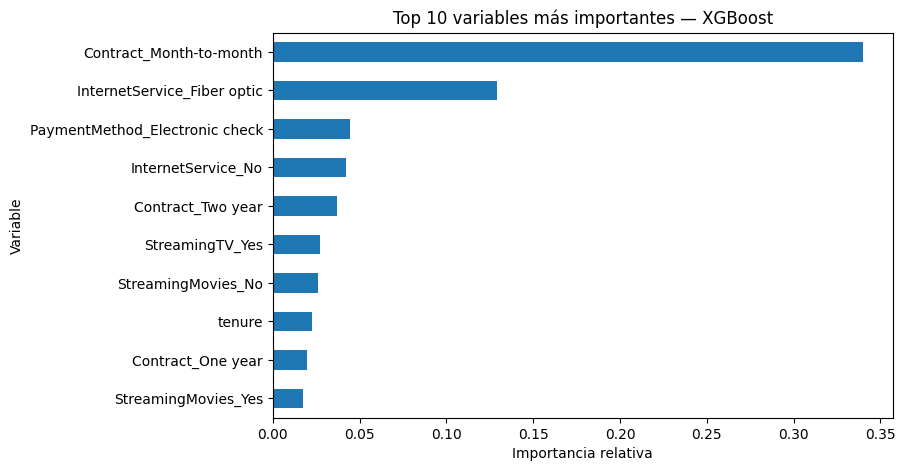

Contract_Month-to-month           0.340175
InternetService_Fiber optic       0.129141
PaymentMethod_Electronic check    0.044262
InternetService_No                0.042373
Contract_Two year                 0.036714
StreamingTV_Yes                   0.027401
StreamingMovies_No                0.025905
tenure                            0.022423
Contract_One year                 0.019539
StreamingMovies_Yes               0.017243
dtype: float32

In [41]:
# Nombres de features después del OneHot del pipeline
ohe = best_xgb.named_steps['preprocess'].named_transformers_['cat']
num_features = num_cols
cat_features = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_features, cat_features])

# Importancias desde el estimador XGBoost
xgb_model = best_xgb.named_steps['model']
importances = pd.Series(xgb_model.feature_importances_, index=feature_names)

# Top-10
top_imp_xgb = importances.sort_values(ascending=False).head(10)

# Gráfico
plt.figure(figsize=(8, 5))
top_imp_xgb.sort_values().plot.barh()
plt.title("Top 10 variables más importantes — XGBoost")
plt.xlabel("Importancia relativa")
plt.ylabel("Variable")
plt.show()

# tabla
top_imp_xgb

Las importancias de **XGBoost** están fuertemente concentradas en **`Contract_Month-to-month`**, muy por encima del resto, seguido por **`InternetService_Fiber optic`**. Luego aparecen factores económicos/comerciales como **`PaymentMethod_Electronic check`** y la ausencia de internet (**`InternetService_No`**), además de la duración del contrato (**`Contract_Two year`**, **`Contract_One year`**) y **`tenure`** con peso menor. También figuran señales de uso (**`StreamingTV_Yes`**, **`StreamingMovies_Yes/No`**), todas alineadas con el patrón visto en RF: tipo de contrato, servicio de internet y método de pago son los impulsores principales del churn. ¿Seguimos con CatBoost o LightGBM?


# **CatBoost**

Entrenando CatBoost...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Mejores parámetros: {'model__bagging_temperature': 0.2, 'model__border_count': 32, 'model__depth': 4, 'model__iterations': 300, 'model__l2_leaf_reg': 5, 'model__learning_rate': 0.05}
Mejor AUC (CV): 0.8479

Accuracy: 0.801
Precision: 0.659
Recall: 0.521
F1: 0.582
AUC: 0.845


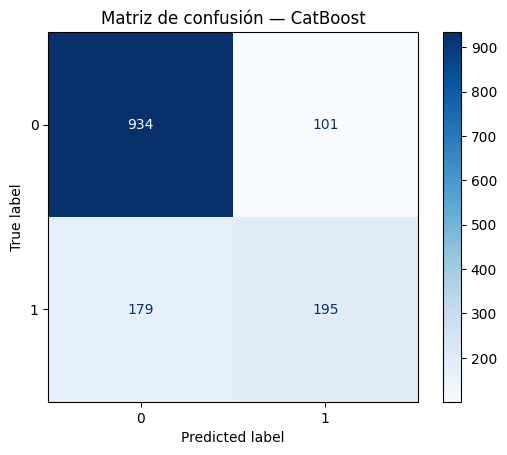

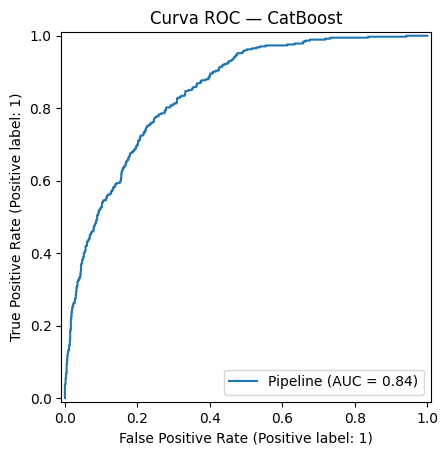

In [44]:
# Validación cruzada estratificada
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Modelo base
cat = CatBoostClassifier(
    random_seed=RANDOM_STATE,
    eval_metric='AUC',
    silent=True,
    allow_writing_files=False,   
    thread_count=-1
)


pipe_cat = Pipeline(steps=[("preprocess", preprocess), ("model", cat)])

# Espacio de hiperparámetros
param_grid_cat = {
    "model__depth": [4, 6, 8],
    "model__l2_leaf_reg": [1, 3, 5],
    "model__bagging_temperature": [0.2, 1, 5],
    "model__border_count": [32, 64],
    "model__learning_rate": [0.05, 0.1],
    "model__iterations": [300, 500]
}

# GridSearchCV
gs_cat = GridSearchCV(
    estimator=pipe_cat,
    param_grid=param_grid_cat,
    cv=cv5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

print("Entrenando CatBoost...")
gs_cat.fit(X_train, y_train)

print("\nMejores parámetros:", gs_cat.best_params_)
print("Mejor AUC (CV):", round(gs_cat.best_score_, 4))

# Evaluación
best_cat = gs_cat.best_estimator_
y_pred = best_cat.predict(X_test)
y_proba = best_cat.predict_proba(X_test)[:, 1]

print("\nAccuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Precision:", round(precision_score(y_test, y_pred), 3))
print("Recall:", round(recall_score(y_test, y_pred), 3))
print("F1:", round(f1_score(y_test, y_pred), 3))
print("AUC:", round(roc_auc_score(y_test, y_proba), 3))

# Matriz de confusión
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap="Blues")
plt.title("Matriz de confusión — CatBoost")
plt.show()

# Curva ROC
RocCurveDisplay.from_estimator(best_cat, X_test, y_test)
plt.title("Curva ROC — CatBoost")
plt.show()


El modelo **CatBoost** ofrece un desempeño muy similar al de **Random Forest**, con un balance adecuado entre precisión y sensibilidad.

La **matriz de confusión** muestra que el modelo predice correctamente la mayoría de los casos negativos (934 verdaderos negativos) y una porción considerable de los positivos (195 verdaderos positivos). Aun así, persisten algunos falsos negativos (179) y falsos positivos (101), aunque en menor proporción que con XGBoost.

En las métricas, se alcanza una **exactitud del 80.1 %**, con una **precisión del 65.9 %**, lo que indica buena confianza en las predicciones de abandono. El **recall del 52.1 %** evidencia una detección razonable de clientes que efectivamente cancelan, y el **F1-score (0.582)** refleja equilibrio entre precisión y cobertura. El **AUC de 0.845** confirma la buena capacidad del modelo para distinguir entre clientes que se mantienen y los que abandonan.

En conjunto, **CatBoost combina estabilidad, interpretabilidad y rendimiento competitivo**, situándose entre las mejores alternativas para el problema de churn sin sobreajustar.


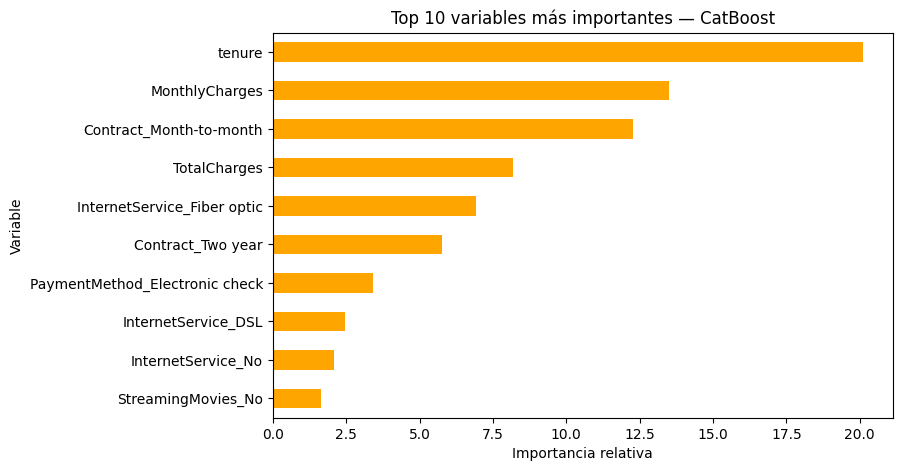

tenure                            20.117609
MonthlyCharges                    13.502503
Contract_Month-to-month           12.276829
TotalCharges                       8.174842
InternetService_Fiber optic        6.938982
Contract_Two year                  5.775570
PaymentMethod_Electronic check     3.420433
InternetService_DSL                2.443844
InternetService_No                 2.100322
StreamingMovies_No                 1.630202
dtype: float64

In [45]:
# Obtener nombres de las features (numéricas + categóricas codificadas)
ohe = best_cat.named_steps['preprocess'].named_transformers_['cat']
num_features = num_cols
cat_features = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_features, cat_features])

# Obtener importancias desde el modelo CatBoost
cat_model = best_cat.named_steps['model']
importances = pd.Series(cat_model.feature_importances_, index=feature_names)

# Seleccionar las 10 más importantes
top_imp_cat = importances.sort_values(ascending=False).head(10)

# Graficar
plt.figure(figsize=(8, 5))
top_imp_cat.sort_values().plot.barh(color="orange")
plt.title("Top 10 variables más importantes — CatBoost")
plt.xlabel("Importancia relativa")
plt.ylabel("Variable")
plt.show()

# Mostrar tabla
top_imp_cat

El modelo **CatBoost** confirma el patrón observado en los modelos anteriores, pero con una jerarquía de variables más clara.
La característica **`tenure`** (tiempo de permanencia del cliente) destaca como la más influyente con amplia diferencia, reafirmando que los usuarios con menor antigüedad tienen una mayor propensión a cancelar el servicio.

Le siguen variables de carácter económico y contractual, como **`MonthlyCharges`**, **`Contract_Month-to-month`** y **`TotalCharges`**, que reflejan el impacto del costo y la modalidad del contrato sobre la decisión de continuar o no con la compañía. También sobresalen factores asociados al tipo de conexión, en especial **`InternetService_Fiber optic`**, que sugiere posibles problemas de satisfacción o costo en ese segmento.

Finalmente, aparecen en menor medida el método de pago (**`PaymentMethod_Electronic check`**) y algunas categorías del servicio de internet y entretenimiento (**`InternetService_DSL`**, **`StreamingMovies_No`**).
En conjunto, **CatBoost** enfatiza la relevancia de la permanencia, los costos y el tipo de contrato como los principales determinantes del *churn*, en línea con lo que se espera en un entorno de telecomunicaciones.


# **LightGBM**

Entrenando LightGBM...
Fitting 5 folds for each of 576 candidates, totalling 2880 fits

Mejores parámetros: {'model__colsample_bytree': 0.7, 'model__max_depth': 20, 'model__min_child_samples': 10, 'model__min_child_weight': 0.001, 'model__num_leaves': 31, 'model__reg_alpha': 0.5, 'model__reg_lambda': 1.0, 'model__subsample': 0.7}
Mejor AUC (CV): 0.8251

Accuracy: 0.785
Precision: 0.612
Recall: 0.519
F1: 0.562
AUC: 0.821


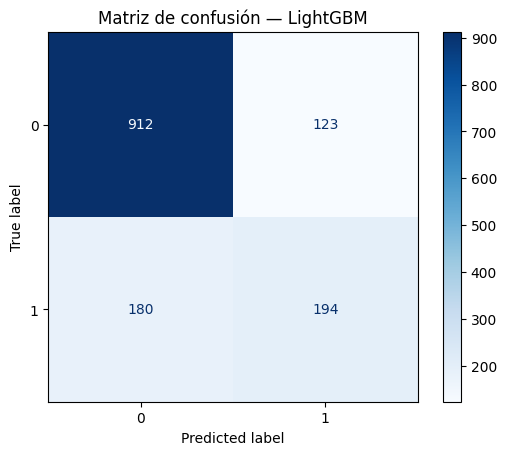

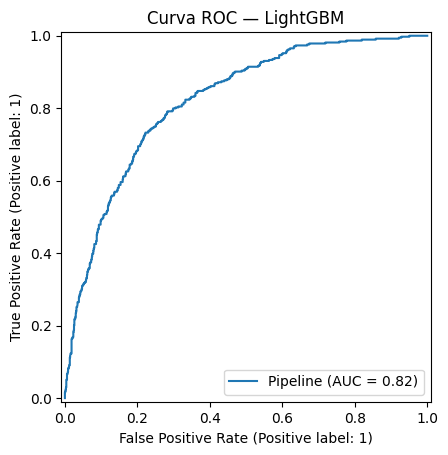

In [46]:
# Validación cruzada
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Modelo base
lgb = LGBMClassifier(
    random_state=RANDOM_STATE,
    n_estimators=500,
    objective='binary',
    n_jobs=-1,
    verbose=-1
)

pipe_lgb = Pipeline(steps=[("preprocess", preprocess), ("model", lgb)])

# Espacio de hiperparámetros
param_grid_lgb = {
    "model__num_leaves": [31, 63],
    "model__max_depth": [-1, 10, 20],
    "model__min_child_samples": [10, 20, 30],
    "model__min_child_weight": [0.001, 0.01],
    "model__subsample": [0.7, 0.9],
    "model__colsample_bytree": [0.7, 0.9],
    "model__reg_alpha": [0.0, 0.5],
    "model__reg_lambda": [0.0, 1.0]
}

# GridSearchCV
gs_lgb = GridSearchCV(
    estimator=pipe_lgb,
    param_grid=param_grid_lgb,
    cv=cv5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

print("Entrenando LightGBM...")
gs_lgb.fit(X_train, y_train)

print("\nMejores parámetros:", gs_lgb.best_params_)
print("Mejor AUC (CV):", round(gs_lgb.best_score_, 4))

# Evaluación
best_lgb = gs_lgb.best_estimator_
y_pred = best_lgb.predict(X_test)
y_proba = best_lgb.predict_proba(X_test)[:, 1]

print("\nAccuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Precision:", round(precision_score(y_test, y_pred), 3))
print("Recall:", round(recall_score(y_test, y_pred), 3))
print("F1:", round(f1_score(y_test, y_pred), 3))
print("AUC:", round(roc_auc_score(y_test, y_proba), 3))

# Matriz de confusión
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap="Blues")
plt.title("Matriz de confusión — LightGBM")
plt.show()

# Curva ROC
RocCurveDisplay.from_estimator(best_lgb, X_test, y_test)
plt.title("Curva ROC — LightGBM")
plt.show()

El modelo **LightGBM** mantiene un desempeño consistente, con resultados equilibrados entre precisión y capacidad de generalización. La **matriz de confusión** muestra que el modelo identifica correctamente la mayoría de los clientes que permanecen (912 verdaderos negativos) y una parte importante de los que abandonan (194 verdaderos positivos), aunque aún existen falsos negativos y positivos en proporciones moderadas. En las métricas, alcanza una **exactitud del 78.5 %**, con una **precisión del 61.2 %** y un **recall del 51.9 %**, lo que refleja un balance razonable entre aciertos y sensibilidad. El **AUC de 0.821** confirma una buena capacidad discriminativa, aunque ligeramente inferior a la lograda por XGBoost y CatBoost. En conjunto, LightGBM demuestra ser un modelo eficiente y estable, ideal para despliegues rápidos, aunque con un desempeño ligeramente menor en la detección de clientes propensos al abandono.


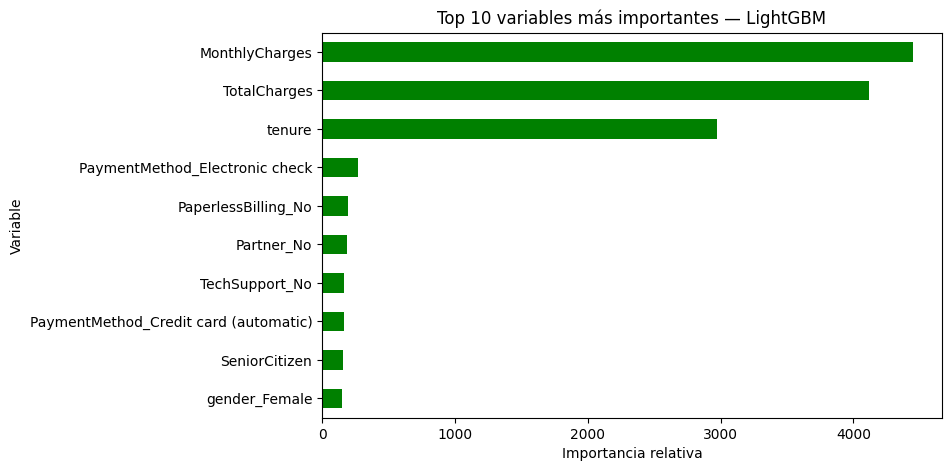

MonthlyCharges                           4445
TotalCharges                             4116
tenure                                   2970
PaymentMethod_Electronic check            269
PaperlessBilling_No                       198
Partner_No                                191
TechSupport_No                            167
PaymentMethod_Credit card (automatic)     163
SeniorCitizen                             156
gender_Female                             147
dtype: int32

In [47]:
# Obtener nombres de features del pipeline
ohe = best_lgb.named_steps['preprocess'].named_transformers_['cat']
num_features = num_cols
cat_features = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_features, cat_features])

# Extraer importancias del modelo LightGBM
lgb_model = best_lgb.named_steps['model']
importances = pd.Series(lgb_model.feature_importances_, index=feature_names)

# Seleccionar las 10 más importantes
top_imp_lgb = importances.sort_values(ascending=False).head(10)

# Graficar
plt.figure(figsize=(8, 5))
top_imp_lgb.sort_values().plot.barh(color="green")
plt.title("Top 10 variables más importantes — LightGBM")
plt.xlabel("Importancia relativa")
plt.ylabel("Variable")
plt.show()

# Mostrar tabla
top_imp_lgb

El modelo **LightGBM** identifica como variables más relevantes aquellas relacionadas con los costos y la permanencia del cliente. **`MonthlyCharges`** y **`TotalCharges`** encabezan la lista, lo que indica que los valores asociados a la facturación tienen un peso determinante en la predicción del churn. En tercer lugar aparece **`tenure`**, reafirmando que la duración del contrato es un indicador clave: los clientes con menor tiempo de antigüedad tienden a abandonar con mayor frecuencia.

Otras variables con menor influencia, pero aún relevantes, son **`PaymentMethod_Electronic check`**, asociada históricamente con mayor probabilidad de churn, y **`PaperlessBilling_No`**, que podría relacionarse con clientes menos familiarizados con los canales digitales. Factores demográficos y de servicio, como **`Partner_No`**, **`SeniorCitizen`** y **`TechSupport_No`**, también aportan información complementaria, aunque con menor impacto. En conjunto, LightGBM refuerza la importancia del costo del servicio, la forma de pago y la lealtad del cliente como los principales determinantes del abandono.


# **Conclusiones finales**

En conclusión, los cuatro modelos —**Random Forest (AUC = 0.842)**, **XGBoost (AUC = 0.844)**, **CatBoost (AUC = 0.845)** y **LightGBM (AUC = 0.821)**— mostraron un rendimiento competitivo en la predicción del *churn* de clientes. **CatBoost** y **XGBoost** alcanzaron las mejores capacidades discriminativas, combinando buena precisión y sensibilidad, mientras que **Random Forest** ofreció resultados estables y de fácil interpretación. **LightGBM**, aunque con un AUC ligeramente menor, destacó por su eficiencia y rapidez de entrenamiento. En conjunto, los modelos evidencian que variables como la **antigüedad del cliente (tenure)**, los **cargos mensuales**, el **tipo de contrato** y el **método de pago** son los principales factores asociados con el abandono, brindando información valiosa para estrategias de retención en telecomunicaciones.


In [51]:
path=os.path.join("..", "app", "model.joblib")
joblib.dump(best_cat, path)

['..\\app\\model.joblib']